# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda

Vamos trabalhar com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

df = pd.read_csv('previsao_de_renda.csv', parse_dates=['data_ref'])
df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               15000 non-null  datetime64[ns]
 1   id_cliente             15000 non-null  int64         
 2   sexo                   15000 non-null  object        
 3   posse_de_veiculo       15000 non-null  bool          
 4   posse_de_imovel        15000 non-null  bool          
 5   qtd_filhos             15000 non-null  int64         
 6   tipo_renda             15000 non-null  object        
 7   educacao               15000 non-null  object        
 8   estado_civil           15000 non-null  object        
 9   tipo_residencia        15000 non-null  object        
 10  idade                  15000 non-null  int64         
 11  tempo_emprego          12427 non-null  float64       
 12  qt_pessoas_residencia  15000 non-null  float64       
 13  r

1. Ajuste um modelo para prever log(renda) considerando todas as covariáveis disponíveis.
    - Utilizando os recursos do Patsy, coloque as variáveis qualitativas como *dummies*.
    - Mantenha sempre a categoria mais frequente como casela de referência
    - Avalie os parâmetros e veja se parecem fazer sentido prático.

2. Remova a variável menos significante e analise:
    - Observe os indicadores que vimos, e avalie se o modelo melhorou ou piorou na sua opinião.
    - Observe os parâmetros e veja se algum se alterou muito.

3. Siga removendo as variáveis menos significantes, sempre que o *p-value* for menor que 5%. Compare o modelo final com o inicial. Observe os indicadores e conclua se o modelo parece melhor. 
    

# 1

In [8]:
# selecionando variáveis qualitativas
var_qual = df.select_dtypes(include=['object','bool'])
var_qual.head()

,sexo,posse_de_veiculo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia
0,F,False,True,Empresário,Secundário,Solteiro,Casa
1,M,True,True,Assalariado,Superior completo,Casado,Casa
2,F,True,True,Empresário,Superior completo,Casado,Casa
3,F,False,True,Servidor público,Superior completo,Casado,Casa
4,M,True,False,Assalariado,Secundário,Solteiro,Governamental


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Secundário'),
  Text(1, 0, 'Superior completo'),
  Text(2, 0, 'Superior incompleto'),
  Text(3, 0, 'Primário'),
  Text(4, 0, 'Pós graduação')])

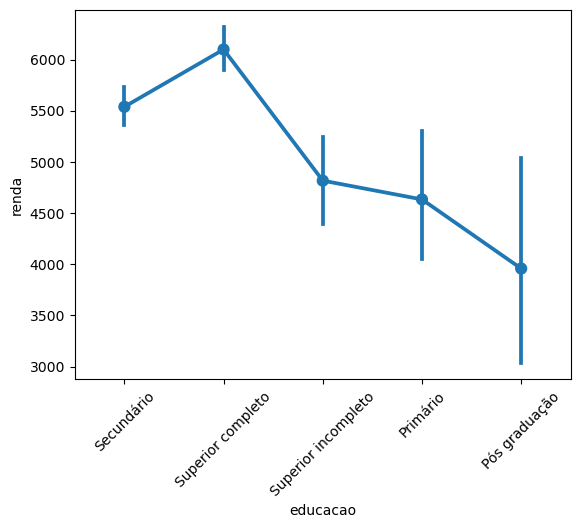

In [9]:
# exemplo de variável qualitativa 
sns.pointplot(y = 'renda', x = 'educacao', data = df)
plt.xticks(rotation=45)

In [10]:
var_qual['tipo_renda'].value_counts()

Assalariado         7633
Empresário          3508
Pensionista         2582
Servidor público    1268
Bolsista               9
Name: tipo_renda, dtype: int64

In [11]:
var_qual.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

In [12]:
df.columns

Index(['data_ref', 'id_cliente', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')

In [13]:
# variáveis qualitativas como dummies - colocando Treatment para variável mais frequente (não vou usar a data_ref nem id_cliente)
y, x = patsy.dmatrices('''
                       np.log(renda) ~ 
                               C(sexo, Treatment(0))
                               + C(tipo_renda, Treatment(0))
                               + C(educacao, Treatment(2))
                               + C(estado_civil, Treatment(0))
                               + C(tipo_residencia, Treatment(1))
                               + C(posse_de_veiculo, Treatment(0))
                               + C(posse_de_imovel, Treatment(1))
                               + qtd_filhos
                               + idade
                               + tempo_emprego
                               + qt_pessoas_residencia
                       ''', data = df)
x

DesignMatrix with shape (12427, 25)
  Columns:
    ['Intercept',
     'C(sexo, Treatment(0))[T.M]',
     'C(tipo_renda, Treatment(0))[T.Bolsista]',
     'C(tipo_renda, Treatment(0))[T.Empresário]',
     'C(tipo_renda, Treatment(0))[T.Pensionista]',
     'C(tipo_renda, Treatment(0))[T.Servidor público]',
     'C(educacao, Treatment(2))[T.Primário]',
     'C(educacao, Treatment(2))[T.Pós graduação]',
     'C(educacao, Treatment(2))[T.Superior completo]',
     'C(educacao, Treatment(2))[T.Superior incompleto]',
     'C(estado_civil, Treatment(0))[T.Separado]',
     'C(estado_civil, Treatment(0))[T.Solteiro]',
     'C(estado_civil, Treatment(0))[T.União]',
     'C(estado_civil, Treatment(0))[T.Viúvo]',
     'C(tipo_residencia, Treatment(1))[T.Aluguel]',
     'C(tipo_residencia, Treatment(1))[T.Com os pais]',
     'C(tipo_residencia, Treatment(1))[T.Comunitário]',
     'C(tipo_residencia, Treatment(1))[T.Estúdio]',
     'C(tipo_residencia, Treatment(1))[T.Governamental]',
     'C(posse_de_v

In [26]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     530.1
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:46:04   Log-Likelihood:                -13572.
No. Observations:               12427   AIC:                         2.717e+04
Df Residuals:                   12413   BIC:                         2.728e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           6.5987      0.218     30.210      0.000       6.171       7.027
C(sexo, Treatment(0))[T.M]                          0.7897      0.015     54.092      0.000       0.761       0.818
C(tipo_renda, Treatment(0))[T.Empresário]           0.1550      0.015     10.413      0.000       0.126       0.184
C(tipo_renda, Treatment(0))[T.Servidor público]     0.0591      0.022      2.661      0.008       0.016       0.103
C(educacao, Treatment(0))[T.Superior completo]      0.1096      0.014      8.078      0.000       0.083       0.136
C(estado_civil, Treatment(2))[T.Separado]           0.3313      0.111      2.979      0.003       0.113       0.549
C(estado_civil, Treatment(2))[T.Solteiro]           0.2709      0.109      2.489      0.013       0.058       0.484
C(estado_civil, Treatment(2))[T.Viúvo]              0.3713      0.116      3.213      0.001       0.145       0.598
C(posse_de_veiculo, Treatment(0))[T.True]           0.0455      0.014      3.230      0.001       0.018       0.073
C(posse_de_imovel, Treatment(1))[T.False]          -0.0833      0.014     -6.077      0.000      -0.110      -0.056
qtd_filhos                                         -0.2657      0.108     -2.462      0.014      -0.477      -0.054
idade                                               0.0054      0.001      6.939      0.000       0.004       0.007
tempo_emprego                                       0.0617      0.001     59.468      0.000       0.060       0.064
qt_pessoas_residencia                               0.2931      0.108      2.721      0.007       0.082       0.504
==============================================================================
Omnibus:                        0.824   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.808
Skew:                           0.019   Prob(JB):                        0.668
Kurtosis:                       3.010   Cond. No.                     2.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 2

In [15]:
df_2 = df.copy()

In [16]:
# vamos fazer as alterações nas faladas acima
df_2['estado_civil'] = df_2['estado_civil'].apply(lambda i: i if i not in ['União', 'Casado'] else 'União/Casado')
df_2['estado_civil'].value_counts()

União/Casado    11612
Solteiro         1798
Separado          879
Viúvo             711
Name: estado_civil, dtype: int64

In [17]:
df_2['educacao'] = df_2['educacao'].apply(lambda i: i if i=='Superior completo' else 'Outros')
df_2['educacao'].value_counts()

Outros               9665
Superior completo    5335
Name: educacao, dtype: int64

In [18]:
df_2['tipo_renda'] = df_2['tipo_renda'].apply(lambda i: i if i not in ['Bolsista', 'Pensionista', 'Assalariado'] else 'Bolsista/Pensionista/Assalariado')
df_2['tipo_renda'].value_counts()

Bolsista/Pensionista/Assalariado    10224
Empresário                           3508
Servidor público                     1268
Name: tipo_renda, dtype: int64

In [19]:
# variáveis qualitativas como dummies
y, x = patsy.dmatrices('''
                       np.log(renda) ~ 
                               C(sexo, Treatment(0))
                               + C(tipo_renda, Treatment(0))
                               + C(educacao, Treatment(0))
                               + C(estado_civil, Treatment(2))
                               + C(posse_de_veiculo, Treatment(0))
                               + C(posse_de_imovel, Treatment(1))
                               + qtd_filhos
                               + idade
                               + tempo_emprego
                               + qt_pessoas_residencia
                       ''', data = df_2)
x

DesignMatrix with shape (12427, 14)
  Columns:
    ['Intercept',
     'C(sexo, Treatment(0))[T.M]',
     'C(tipo_renda, Treatment(0))[T.Empresário]',
     'C(tipo_renda, Treatment(0))[T.Servidor público]',
     'C(educacao, Treatment(0))[T.Superior completo]',
     'C(estado_civil, Treatment(2))[T.Separado]',
     'C(estado_civil, Treatment(2))[T.Solteiro]',
     'C(estado_civil, Treatment(2))[T.Viúvo]',
     'C(posse_de_veiculo, Treatment(0))[T.True]',
     'C(posse_de_imovel, Treatment(1))[T.False]',
     'qtd_filhos',
     'idade',
     'tempo_emprego',
     'qt_pessoas_residencia']
  Terms:
    'Intercept' (column 0)
    'C(sexo, Treatment(0))' (column 1)
    'C(tipo_renda, Treatment(0))' (columns 2:4)
    'C(educacao, Treatment(0))' (column 4)
    'C(estado_civil, Treatment(2))' (columns 5:8)
    'C(posse_de_veiculo, Treatment(0))' (column 8)
    'C(posse_de_imovel, Treatment(1))' (column 9)
    'qtd_filhos' (column 10)
    'idade' (column 11)
    'tempo_emprego' (column 12)
    '

In [20]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     530.1
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:41:22   Log-Likelihood:                -13572.
No. Observations:               12427   AIC:                         2.717e+04
Df Residuals:                   12413   BIC:                         2.728e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           6.5987      0.218     30.210      0.000       6.171       7.027
C(sexo, Treatment(0))[T.M]                          0.7897      0.015     54.092      0.000       0.761       0.818
C(tipo_renda, Treatment(0))[T.Empresário]           0.1550      0.015     10.413      0.000       0.126       0.184
C(tipo_renda, Treatment(0))[T.Servidor público]     0.0591      0.022      2.661      0.008       0.016       0.103
C(educacao, Treatment(0))[T.Superior completo]      0.1096      0.014      8.078      0.000       0.083       0.136
C(estado_civil, Treatment(2))[T.Separado]           0.3313      0.111      2.979      0.003       0.113       0.549
C(estado_civil, Treatment(2))[T.Solteiro]           0.2709      0.109      2.489      0.013       0.058       0.484
C(estado_civil, Treatment(2))[T.Viúvo]              0.3713      0.116      3.213      0.001       0.145       0.598
C(posse_de_veiculo, Treatment(0))[T.True]           0.0455      0.014      3.230      0.001       0.018       0.073
C(posse_de_imovel, Treatment(1))[T.False]          -0.0833      0.014     -6.077      0.000      -0.110      -0.056
qtd_filhos                                         -0.2657      0.108     -2.462      0.014      -0.477      -0.054
idade                                               0.0054      0.001      6.939      0.000       0.004       0.007
tempo_emprego                                       0.0617      0.001     59.468      0.000       0.060       0.064
qt_pessoas_residencia                               0.2931      0.108      2.721      0.007       0.082       0.504
==============================================================================
Omnibus:                        0.824   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.662   Jarque-Bera (JB):                0.808
Skew:                           0.019   Prob(JB):                        0.668
Kurtosis:                       3.010   Cond. No.                     2.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3

In [28]:
df_2.loc[df_2['qtd_filhos']>=2, 'qtd_filhos'] = '2+'
df_2['qtd_filhos'].value_counts()

TypeError: '>=' not supported between instances of 'str' and 'int'

In [29]:
df_2.loc[df_2['qt_pessoas_residencia']>=4, 'qt_pessoas_residencia'] = '4+'
df_2['qt_pessoas_residencia'].value_counts()

2.0    8181
1.0    2752
3.0    2551
4+     1516
Name: qt_pessoas_residencia, dtype: int64

In [30]:
y, x = patsy.dmatrices('''
                       np.log(renda) ~ 
                               C(sexo, Treatment(0))
                               + C(tipo_renda, Treatment(0))
                               + C(educacao, Treatment(0))
                               + C(estado_civil, Treatment(2))
                               + C(posse_de_veiculo, Treatment(0))
                               + C(posse_de_imovel, Treatment(1))
                               + C(qtd_filhos)
                               + idade
                               + tempo_emprego
                               + C(qt_pessoas_residencia, Treatment(2))
                       ''', data = df_2)
x

DesignMatrix with shape (12427, 17)
  Columns:
    ['Intercept',
     'C(sexo, Treatment(0))[T.M]',
     'C(tipo_renda, Treatment(0))[T.Empresário]',
     'C(tipo_renda, Treatment(0))[T.Servidor público]',
     'C(educacao, Treatment(0))[T.Superior completo]',
     'C(estado_civil, Treatment(2))[T.Separado]',
     'C(estado_civil, Treatment(2))[T.Solteiro]',
     'C(estado_civil, Treatment(2))[T.Viúvo]',
     'C(posse_de_veiculo, Treatment(0))[T.True]',
     'C(posse_de_imovel, Treatment(1))[T.False]',
     'C(qtd_filhos)[T.1]',
     'C(qtd_filhos)[T.2+]',
     'C(qt_pessoas_residencia, Treatment(2))[T.1.0]',
     'C(qt_pessoas_residencia, Treatment(2))[T.3.0]',
     'C(qt_pessoas_residencia, Treatment(2))[T.4+]',
     'idade',
     'tempo_emprego']
  Terms:
    'Intercept' (column 0)
    'C(sexo, Treatment(0))' (column 1)
    'C(tipo_renda, Treatment(0))' (columns 2:4)
    'C(educacao, Treatment(0))' (column 4)
    'C(estado_civil, Treatment(2))' (columns 5:8)
    'C(posse_de_veiculo,

In [31]:
sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(renda)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     431.1
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:50:05   Log-Likelihood:                -13570.
No. Observations:               12427   AIC:                         2.717e+04
Df Residuals:                   12410   BIC:                         2.730e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           7.1667      0.037    192.254      0.000       7.094       7.240
C(sexo, Treatment(0))[T.M]                          0.7891      0.015     53.989      0.000       0.760       0.818
C(tipo_renda, Treatment(0))[T.Empresário]           0.1548      0.015     10.401      0.000       0.126       0.184
C(tipo_renda, Treatment(0))[T.Servidor público]     0.0579      0.022      2.608      0.009       0.014       0.101
C(educacao, Treatment(0))[T.Superior completo]      0.1089      0.014      8.023      0.000       0.082       0.136
C(estado_civil, Treatment(2))[T.Separado]           0.2860      0.104      2.746      0.006       0.082       0.490
C(estado_civil, Treatment(2))[T.Solteiro]           0.2257      0.102      2.203      0.028       0.025       0.427
C(estado_civil, Treatment(2))[T.Viúvo]              0.3217      0.110      2.925      0.003       0.106       0.537
C(posse_de_veiculo, Treatment(0))[T.True]           0.0451      0.014      3.201      0.001       0.017       0.073
C(posse_de_imovel, Treatment(1))[T.False]          -0.0824      0.014     -6.003      0.000      -0.109      -0.055
C(qtd_filhos)[T.1]                                 -0.2134      0.104     -2.045      0.041      -0.418      -0.009
C(qtd_filhos)[T.2+]                                -0.5148      0.209     -2.459      0.014      -0.925      -0.104
C(qt_pessoas_residencia, Treatment(2))[T.1.0]      -0.2378      0.103     -2.318      0.020      -0.439      -0.037
C(qt_pessoas_residencia, Treatment(2))[T.3.0]       0.2630      0.105      2.509      0.012       0.057       0.469
C(qt_pessoas_residencia, Treatment(2))[T.4+]        0.5882      0.210      2.805      0.005       0.177       0.999
idade                                               0.0057      0.001      7.192      0.000       0.004       0.007
tempo_emprego                                       0.0616      0.001     59.388      0.000       0.060       0.064
==============================================================================
Omnibus:                        0.985   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.611   Jarque-Bera (JB):                0.966
Skew:                           0.021   Prob(JB):                        0.617
Kurtosis:                       3.012   Cond. No.                     2.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""